# Detecting Credit Card Transaction Fraud using Machine Learning

Consumers lost over $6 billion to online credity card fraud in 2021 as per the [Wall Street Journal](https://www.wsj.com/articles/borrower-beware-credit-card-fraud-attempts-rise-during-the-coronavirus-crisis-11590571800). Therefore, there is a need to develop tools that can alert customers and banks when such type of fradulent activity is attempted as a prevetitive measure. Treating fraudulent and non-fradulent transactions as distinct classes, this problem can be boiled down to a classification task through machine learning.

Another problem that can be foreseen while developing machine learning based tools to prevent fradulent transactions is that credit card transaction data contains highly confidential personal information. Therefore, access to credit card transaction data is highly restricted.

With these motivations, this notebook showcases a two step case study illustrating the power of machine learning in detecting credit card transaction fraud. In the first step, synthetic data using [Sparkov Data Generator](https://github.com/namebrandon/Sparkov_Data_Generation) was generated for 750 customers from 1-1-2019 to 12-31-2021 for almost 1 million unique transactions. The generated data resembles realistic credit card transaction data and can be used for training machine learning models. The feature engineering and data augmentation techniques such as SMOTE can be applied to improve model performance on real life data for classification of fraudulent from non-fraudulent transactions.

In [1]:
# Import libraries
import pandas as pd
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from collections import Counter
from imblearn.over_sampling import SMOTE

# Data Generation and Ingestion

The data was generated using [Sparkov Data Generator](https://github.com/namebrandon/Sparkov_Data_Generation) for 750 unique customer profiles and between dates 1-1-2019 and 12-31-2021. The assigned weights for the profiles were adjusted to allow for only 2 transactions per day at maximum to limit the overall number of transactions per customer to a realistic number. Subsequetly, the following command was used to generate synthetic data resulting in almost 1 million unique transactions:
- python datagen.py -n 750 -o ".\data\transactions" 1-1-2019 12-31-2021

In [2]:
# Get CSV files list from a folder
csv_files = glob.glob('C:/Sparkov_Data_Generation-master/data/transactions/*.csv')
# Create a list of CSV files
df_list = (pd.read_csv(file, sep = '|') for file in csv_files)
# Concatenate all CSV files
df = pd.concat(df_list, ignore_index=True)

In [3]:
len(df)

978647

In [4]:
pd.options.display.max_columns = 999

In [5]:
df.head(10)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,786727dfd3a5a3feb9c60c27114440fc,2020-01-16,01:21:29,1579117889,grocery_pos,340.72,1,"Koepp-Parker,",43.880796,-69.658596
1,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,41a2a6ca54838c02f72a5901e7d4c0f1,2020-01-17,12:59:16,1579246156,kids_pets,20.26,1,"Breitenberg-Hermiston,",45.150789,-68.722362
2,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,3f93f2980857b84610b9d3388d92b6e7,2019-03-18,05:19:47,1552866587,gas_transport,88.5,0,"Kutch LLC,",43.430864,-68.782674
3,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,7ba69d630311c508751e505324645863,2019-05-18,11:03:36,1558157616,gas_transport,72.9,0,"Ledner-Pfannerstill,",43.424425,-68.984921
4,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,553fc818411b90feaab83ae6e6fd7057,2019-08-23,02:33:09,1566507789,grocery_pos,34.11,0,"DuBuque LLC,",44.807573,-68.58357
5,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,bb90dad4147525cffaf09cc74d0cde13,2019-04-19,01:36:42,1555618002,gas_transport,43.87,0,"Eichmann, Bogan and Rodriguez",45.17935,-69.514616
6,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,3fc3e97eb6f35bbc2b20e658f2ffc8d6,2019-01-01,09:30:52,1546315252,gas_transport,76.24,0,"Raynor, Feest and Miller",43.442554,-69.372496
7,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,fe6f1523f44f3cda220604be4579e1a1,2019-10-28,05:47:17,1572221837,grocery_pos,65.85,0,"Miller-Hauck,",44.681119,-69.745366
8,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,cbb391e8954515628328efc39312620a,2019-04-30,05:56:33,1556583993,gas_transport,79.82,0,"Zieme, Bode and Dooley",43.87234,-69.479339
9,075-92-3336,30399006314033,Mary,Herman,F,63560 Donald Gateway Suite 694,Morrill,ME,4952,44.4107,-69.1471,1829,"Engineer, energy",1977-11-24,966111115187,adults_2550_female_rural.json,84cb13981a02bd8a4161fc89bb0850c9,2019-01-26,08:01:48,1548469908,gas_transport,53.45,0,"Koss and Sons,",43.883949,-68.998343


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978647 entries, 0 to 978646
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ssn         978647 non-null  object
 1   cc_num      978647 non-null  object
 2   first       978647 non-null  object
 3   last        978647 non-null  object
 4   gender      978647 non-null  object
 5   street      978647 non-null  object
 6   city        978647 non-null  object
 7   state       978647 non-null  object
 8   zip         978647 non-null  object
 9   lat         978647 non-null  object
 10  long        978647 non-null  object
 11  city_pop    978647 non-null  object
 12  job         978647 non-null  object
 13  dob         978647 non-null  object
 14  acct_num    978647 non-null  object
 15  profile     978647 non-null  object
 16  trans_num   977897 non-null  object
 17  trans_date  977897 non-null  object
 18  trans_time  977897 non-null  object
 19  unix_time   977897 non-

In [7]:
df = df.dropna()

In [8]:
df.isna().sum()

ssn           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
acct_num      0
profile       0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

In [9]:
df['amt'] = df.amt.astype('float');
df['is_fraud'] = df.is_fraud.astype('int');
df.amt.describe()

count    977897.000000
mean         69.112599
std         159.788062
min           1.000000
25%           9.180000
50%          45.570000
75%          82.540000
max       19159.940000
Name: amt, dtype: float64

# Data Dictionary
- **ssn**: Social Security Number of the Credit Card Holder
- **cc_num**: Credit Card Number
- **first**: First Name of the Credit Card Holder
- **last**: Last Name of the Credit Card Holder
- **gender**: Sex of the Credit Card Holder
- **street**: Address of the transaction
- **city**: City of the transaction
- **state**: State of the transaction
- **zip**: Zipcode of the transaction
- **lat**: Latitude of the Transaction
- **long**: Longitude of the Transaction
- **city_pop**: Population of the City of the Card Holder
- **job**: Job of the Card Holder
- **dob**: Date of birth of the Card Holder
- **acct_num**: Account number of the Card Holder
- **profile**: Filename containing profile weights of the Card Holder
- **trans_num**: Unique ID of the transaction
- **trans_date**: Transaction date
- **trans_time**: Transaction time 
- **unix_time**: Transaction time in Unix Format
- **category**: Category of the transaction
- **amt**: Amount of the transaction
- **is_fraud**: Identifier for fraud or non-fraud transactions (1 implies fraud)
- **merchant**: Name of merchant for transaction
- **merch_lat**: Latitude of merchant of transaction
- **merch_long**: Longitude of merchant of transaction

In [10]:
#Calculate percentage of fraud transactions in each spending category
fraud_txn = (df.query("is_fraud == 1")['category']
             .value_counts(normalize = False)
             .to_frame()
             .reset_index())
not_fraud_txn = (df.query("is_fraud == 0")['category']
                 .value_counts(normalize = False)
                 .to_frame()
                 .reset_index())
fraud_txn.columns = ['category','fraud_txn']
not_fraud_txn.columns = ['category','not_fraud_txn']
category_txn =  fraud_txn.merge(not_fraud_txn, on = 'category')
category_txn['percentage_fraud'] = (category_txn['fraud_txn']/category_txn['not_fraud_txn'])*100

In [11]:
pio.renderers
pio.renderers.default = "svg"

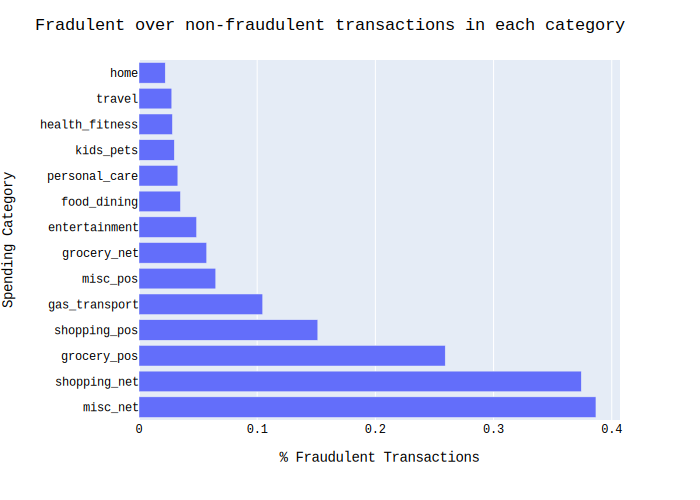

In [12]:
#Plot percentage of fraud transactions in each spending categor
category_txn_sorted = category_txn.sort_values('percentage_fraud', ascending = False)
fig = px.bar(category_txn_sorted, x='percentage_fraud', y='category', orientation='h')

fig.update_layout(
    title="Fradulent over non-fraudulent transactions in each category",
    xaxis_title="% Fraudulent Transactions",
    yaxis_title="Spending Category",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="black"
    )
)

fig.show()

It can be seen from the plot that a very small percentage of the transactions are fraudulent. This highlights a severe class imbalance where one of the classes (fraudulent transactions) constitutes a less than 0.4% of the total dataset. Therefore, there is a need for feature engineering and data augmentation methods for improving model performance.

In [13]:
df_states = df.groupby(by='state').sum()["is_fraud"].to_frame()
df_states.reset_index(inplace = True)
df_states = df_states.rename(columns = {"state": "State", "is_fraud":"Fraudlent Transactions"})

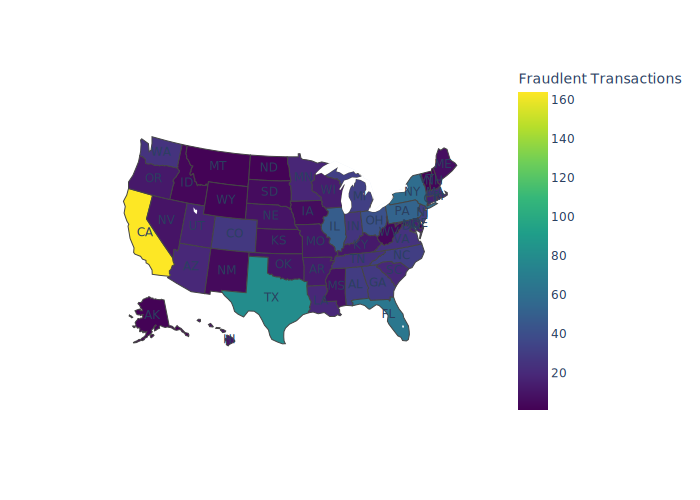

In [14]:
fig = px.choropleth(df_states, locations='State', color="Fraudlent Transactions",
                     locationmode = 'USA-states',
                     color_continuous_scale = 'Viridis',
                     labels = {'States':'Fraudlent Transactions'},
                     scope = 'usa')
fig.add_scattergeo(
locations = df_states['State'],
locationmode = 'USA-states',
text = df_states['State'],
mode = 'text')

fig.show()

# Feature Engineering

Typically, fraudulent transactions will occur when an individual is not actively monitoring their accounts. Accordingly, it makes sense to explore the time at which fraudulent and non fraudulent transactions occur. Furthermore, it's also important to visualize the dollar value of each of the fraudulent transaction as compared to the non-fraudulent transactions. The visualizations can then be used to define new features that can improve model performance when classifying fraudulent from non fraudulent transactions. 

In [15]:
df["trans_time"] = pd.to_datetime(df["trans_time"])
df["trans_date"] = pd.to_datetime(df["trans_date"])

In [16]:
df['year'] = df.trans_date.dt.year
df['month'] = df.trans_date.dt.month
df['hour'] = df.trans_time.dt.hour

In [17]:
pio.renderers
pio.renderers.default = "svg"

<AxesSubplot:xlabel='hour', ylabel='amt'>

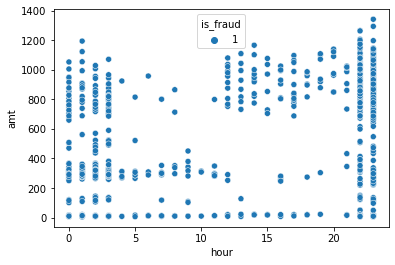

In [18]:
fraud_txn2 = (df.query("is_fraud == 1"))
sns.scatterplot(data=fraud_txn2, x="hour", y="amt", hue="is_fraud")
# fig = px.scatter(fraud_txn2, x='hour', y='amt')

# fig.update_layout(
#     title="Scatter plot of amount versus hour for fraudulent transactions",
#     xaxis_title="Hour",
#     yaxis_title="Amount (US $)",
#     font=dict(
#         family="Courier New, monospace",
#         size=12,
#         color="black"
#     )
# )

# fig.show()

In [19]:
df['abnormal_hour'] = 0
df.loc[df.hour < 4, 'abnormal_hour'] = 1
df.loc[df.hour > 22, 'abnormal_hour'] = 1

In [20]:
#Top 5 jobs with most number of fraud transactions
fraud_job = df.groupby(by=['is_fraud','job']).agg({"amt":'mean',"trans_num":"count"}).fillna(0).reset_index()
fraud_job  = fraud_job [fraud_job .is_fraud==1].sort_values(by='trans_num',
                                       ascending=False).drop_duplicates('job', keep='first').iloc[:5, :]
fraud_job 

,is_fraud,job,amt,trans_num
486,1,Counselling psychologist,743.617778,9
485,1,"Copywriter, advertising",429.461250,8
476,1,Computer games developer,420.641250,8
447,1,Chemical engineer,478.618750,8
791,1,"Therapist, speech and language",395.515714,7


In [21]:
#Top 5 categories with most number of fraud transactions
fraud_category = df.groupby(by=['is_fraud','category']).agg({"amt":'mean',"trans_num":"count"}).fillna(0).reset_index()
fraud_category  = fraud_category [fraud_category .is_fraud==1].sort_values(by='trans_num',
                                       ascending=False).drop_duplicates('category', keep='first').iloc[:5, :]
fraud_category 

,is_fraud,category,amt,trans_num
25,1,shopping_net,957.206220,254
18,1,grocery_pos,320.066446,242
22,1,misc_net,768.910793,164
26,1,shopping_pos,836.052276,145
16,1,gas_transport,48.850227,88


In [22]:
#Top 5 merchants with most number of fraud transactions
fraud_merchant = df.groupby(by=['is_fraud','merchant']).agg({"amt":'mean',"trans_num":"count"}).fillna(0).reset_index()
fraud_merchant  = fraud_merchant [fraud_merchant .is_fraud==1].sort_values(by='trans_num',
                                       ascending=False).drop_duplicates('merchant', keep='first').iloc[:5, :]
fraud_merchant 

,is_fraud,merchant,amt,trans_num
974,1,"Schultz, Simonis and Little",291.550000,12
888,1,"Lockman Ltd,",369.038000,10
792,1,"Gottlieb, Considine and Schultz",960.454444,9
697,1,"Altenwerth, Cartwright and Koss",939.541111,9
698,1,"Ankunding LLC,",1012.935556,9


<AxesSubplot:>

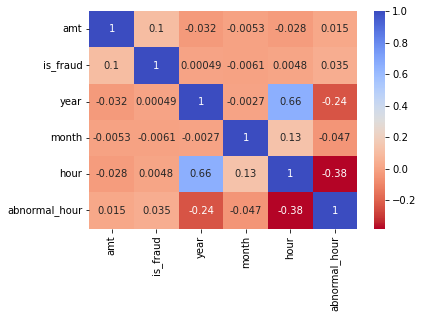

In [23]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot =True)

Therefore, the features to be used include- hour, year, month, category, amt, merchant, job and abnormal_hour as each of these attributes contain information regarding fraudulent versus non-fraudulent transactions. These features can be ordered by trans_num since it is unique for each transaction.

In [24]:
features = ['trans_num', 'hour','year','month', 'category', 'amt', 'merchant', 'job','abnormal_hour']
X = df[features].set_index("trans_num")
y = df['is_fraud']
y = y.astype('int')
#print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

In [25]:
enc = OrdinalEncoder(dtype=np.int64)
enc.fit(X.loc[:,['hour','year','month','category','merchant','job','abnormal_hour']])

X.loc[:, ['hour','year','month','category','merchant','job','abnormal_hour']] = enc.transform(X[['hour','year','month','category','merchant','job','abnormal_hour']])

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977897 entries, 786727dfd3a5a3feb9c60c27114440fc to 00e19ef3e12b1b523c48fcdf29893917
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hour           977897 non-null  int64  
 1   year           977897 non-null  int64  
 2   month          977897 non-null  int64  
 3   category       977897 non-null  int64  
 4   amt            977897 non-null  float64
 5   merchant       977897 non-null  int64  
 6   job            977897 non-null  int64  
 7   abnormal_hour  977897 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 67.1+ MB


In [27]:
X['amt'] = X.amt.astype('float');

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [29]:
RFc = RandomForestClassifier()
RFc.fit(X_train, y_train)

y_pred = RFc.predict(X_test)

<Figure size 576x432 with 0 Axes>

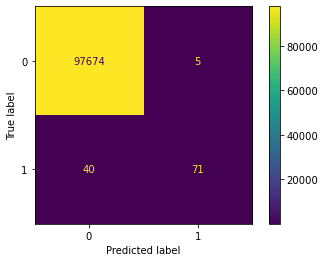

In [32]:
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred, labels = RFc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cfs_matrix, display_labels = RFc.classes_)

disp.plot()
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97679
           1       0.93      0.64      0.76       111

    accuracy                           1.00     97790
   macro avg       0.97      0.82      0.88     97790
weighted avg       1.00      1.00      1.00     97790



# Synthetic Minority Oversampling Technique (SMOTE)

Imbalanced classes pose a significant challenge for machine learning techniques as they would ignore and hence have poor performance on the minority class when performance on the minority class is the most significant metric. An approach for dealing with such class imbalace is to oversample the minority class. Synthetic Minority Oversampling Technique (SMOTE) is one such technique where new records can be synthesized from existing records.

In [34]:
smote = SMOTE(sampling_strategy={1:879104}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Original dataset shape %s" % Counter(y_train))
print("Resampled dataset shape %s" % Counter(y_train_smote))

Original dataset shape Counter({0: 879104, 1: 1003})
Resampled dataset shape Counter({0: 879104, 1: 879104})


In [35]:
RFc_smote = RandomForestClassifier()
RFc_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = RFc_smote.predict(X_test)

=====================SMOTE=====================


<Figure size 576x432 with 0 Axes>

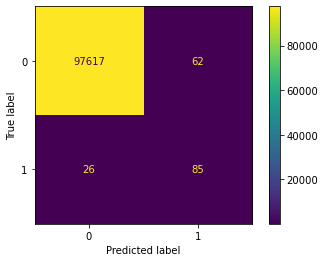

In [36]:
print("=====================SMOTE=====================")
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred_smote, labels = RFc_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cfs_matrix, display_labels = RFc_smote.classes_)

disp.plot()
plt.show()

In [37]:
print("=====================SMOTE=====================")
print(classification_report(y_test, y_pred_smote))

=====================SMOTE=====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97679
           1       0.58      0.77      0.66       111

    accuracy                           1.00     97790
   macro avg       0.79      0.88      0.83     97790
weighted avg       1.00      1.00      1.00     97790



In [38]:
RFc_smote.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
param_grid = { 
    'n_estimators': [200, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
}

In [40]:
CV_RFc = GridSearchCV(estimator=RFc, param_grid=param_grid, cv= 5)
CV_RFc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 400]})

In [41]:
CV_RFc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 400}

In [43]:
RFc_tuned=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 400, max_depth=6, criterion='gini')

RFc_tuned.fit(X_train, y_train)
y_pred_tuned=RFc_tuned.predict(X_test)

=====================TUNED=====================


<Figure size 576x432 with 0 Axes>

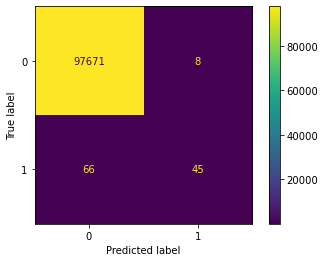

In [44]:
print("=====================TUNED=====================")
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred_tuned, labels = RFc_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cfs_matrix, display_labels = RFc_tuned.classes_)

disp.plot()
plt.show()

In [46]:
print("=====================TUNED=====================")
print(classification_report(y_test, y_pred_tuned))

=====================TUNED=====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97679
           1       0.85      0.41      0.55       111

    accuracy                           1.00     97790
   macro avg       0.92      0.70      0.77     97790
weighted avg       1.00      1.00      1.00     97790



Given the trade-off between precision and recall, increasing the number of samples in the minority class improves the recall but reduces the precision of the model. Thus, machine learning can be applied for fraud detection in credit card transactions. 